In [1]:
from scipy.stats import linregress
from scipy.integrate import simpson, quad
from scipy.optimize import curve_fit
import sys
sys.path.append("../")

from Config import *
from Utilities import *
from Solver import *
from Jam_generator import *
from Functions import *
from Collisions import *

base_path = "../Machine_scripts/Results/Collisions/"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def get_s_least_squares(rho, y):
    
    u_ = u_y(rho, y)
    q = rho * u_

    res = linregress(rho, q)
    s, m = res[0], res[1]
    return s, m


def get_L(v_plus, v_min, s, m, tau, vs, eps=1e-4):
    
    def to_integ(v):
        num = r_prime(v, m)
        den = w_v(v, m, s)
        return v * num/den

    #total = 100_000
    #if s < -2.603016951915652:
    #    total = 10_000

    L_1 = tau * quad(to_integ, v_plus, vs-eps, points=[vs])[0] #dx * np.sum(to_integ(v_to_int)) #simpson(to_integ(v_to_int), dx=dx, x=v_to_int)
    L_2 = tau * quad(to_integ, vs+eps, v_min, points=[vs])[0]
    # L = tau * quad(to_integ, v_plus, v_min, points=[vs])[0]

    L = L_1 + L_2 #L_1 + L_2 + L_3 + L_4
    return L

In [3]:
tau = 5
tf_test = 60
rhos_to_test, rho_s_test, v_minus = get_rho_s_tests()
rho_s_test = rho_s_test/rho_max


# Test Jamiton
x_minus_t, x_plus_t, sol_v_t, sol_v_eta_t, m_t, s_t, values_v_t = jam_values(tau, rho_s_test, tf_test, v_minus=v_minus, print_pars=False)
v_plus_t = values_v_t["v_plus"]

rho_min_t = 1/v_minus
rho_plus_t = 1/v_plus_t

L_t = x_minus_t - x_plus_t #get_L(v_plus_t, v_minus, s_t, m_t, tau, 1/rho_s_test, 1e-1)
A_t = rho_plus_t - rho_min_t

In [4]:
tau = 5
A_test = []
L_test = []
rho_min_test = []
rho_plus_test = []

for rho_test in rhos_to_test:

    if rho_test/rho_max < 0.512:
        tf = 250
    else:
        tf = 1500
    
    x_minus, x_plus, sol_v, sol_v_eta, m, s, values_v = jam_values(tau, rho_test/rho_max, tf, v_minus=v_minus, print_pars=False)
    
    v_plus_col = values_v["v_plus"]
    
    rho_min_col = 1/v_minus
    rho_plus_col = 1/v_plus_col
    
    L = x_minus - x_plus #get_L(v_plus_col, v_minus, s, m, tau, vs)
    A = rho_plus_col - rho_min_col

    L_test += [L]
    A_test += [A]
    rho_min_test += [rho_min_col]
    rho_plus_test += [rho_plus_col]


/Users/sebatapia/Desktop/Jamiton/Test_and_results/../Functions.py:19: RuntimeWarning: invalid value encountered in power
  output =  beta * gamma * (rho /(rho_max - rho))**(gamma-1) * rho_max / ((rho_max - rho)**2)


# Collisions

## $\tau = 5$

In [5]:
dx = 2**(-4)
total_cols = 4
total = int(len(rhos_to_test)/4)

rhos = []
ys = []

tau_5_path = base_path + "tau_5/"

for n in range(total_cols):
    rhos_cols = []
    ys_cols = []

    col_folder = tau_5_path + "Colls_{}_tau_5/".format(n)
    rho_folder = col_folder + "rho/"
    y_folder = col_folder + "y/"
    rhos_collided = rhos_to_test[n*total:(n+1)*total]

    for rho_s in rhos_collided:
        rho_filename = rho_folder + "rho_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
        rho_file = gzip.GzipFile(rho_filename, "r")
        rho = np.load(rho_file)

        y_filename = y_folder + "y_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
        y_file = gzip.GzipFile(y_filename, "r")
        y = np.load(y_file)
        
        rhos_cols += [rho]
        ys_cols += [y]
    rhos += [rhos_cols]
    ys += [ys_cols]
#rhos = np.array(rhos)
#ys = np.array(ys)

In [6]:
rhos_array = np.full(1024, fill_value=None)
ys_array = np.full(1024, fill_value=None)

for j in range(4):
    for n in range(len(rhos[j])):
        rhos_array[n+j*256] = rhos[j][n]
        ys_array[n+j*256] = ys[j][n]

In [7]:
tau = 5
vs_tau_5 = []
s_tau_5 = []
rho_min_tau_5 = []
rho_plus_tau_5 = []
L_tau_5 = []
A_tau_5 = []

for j in range(len(rhos_array)):
    rho = rhos_array[j]
    y = ys_array[j]
    s, m = get_s_least_squares(rho, y)

    rho_min = np.min(rho)
    rho_plus = np.max(rho)

    v_min_col = 1/rho_min
    v_plus_col = 1/rho_plus

    vs = get_v_s(m, s, v_plus_col)
    L_col = get_L(v_plus_col, v_min_col, s, m, tau, vs)
    A_col = rho_plus - rho_min

    vs_tau_5 += [vs] 
    s_tau_5 += [s]
    rho_min_tau_5 += [rho_min]
    rho_plus_tau_5 += [rho_plus]
    L_tau_5 += [L_col]
    A_tau_5 += [A_col]

vs_tau_5 = np.array(vs_tau_5)
s_tau_5 = np.array(s_tau_5)
rho_min_tau_5 = np.array(rho_min_tau_5)
rho_plus_tau_5 = np.array(rho_plus_tau_5)
L_tau_5 = np.array(L_tau_5)
A_tau_5 = np.array(A_tau_5)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_58011/4132445854.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  L_2 = tau * quad(to_integ, vs+eps, v_min, points=[vs])[0]


In [8]:
s_to_test = np.zeros(len(rhos_to_test))

for j in range(len(rhos_to_test)):
    vs = 1/(rhos_to_test[j])
    m = get_m(vs)
    s = get_s(m, vs)
    s_to_test[j] = s

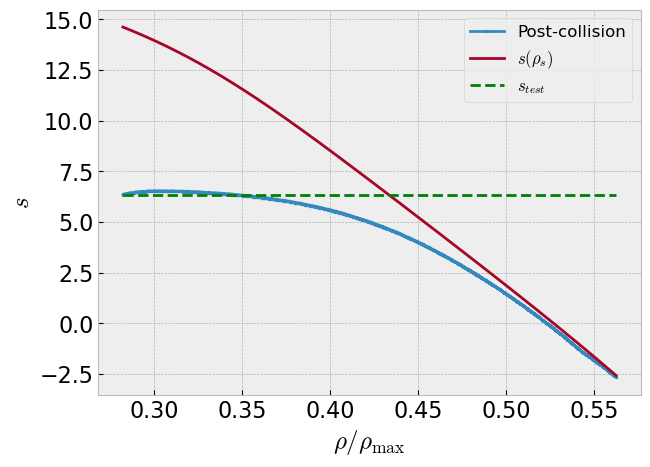

In [9]:
plt.plot(rhos_to_test/rho_max, s_tau_5, "*-", ms=2, label="Post-collision")
plt.plot(rhos_to_test/rho_max, s_to_test, label=r"$s(\rho_s)$")
plt.hlines(s_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")
#plt.vlines(rho_s_test, -5, 8, ls="--", color="green")
plt.legend(fontsize=12)
#plt.ylim(-2.9, 7)
plt.ylabel(r"$s$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.savefig("Img/Collisions/s_coll.pdf", dpi=300, bbox_inches = "tight")
plt.show()

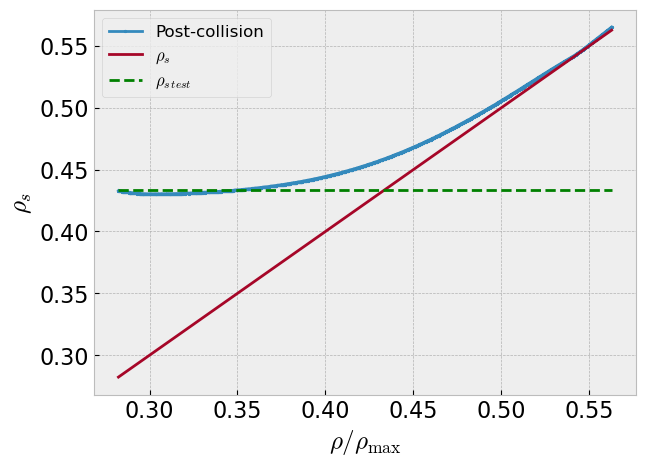

In [10]:
rho_s_tau_5 = 1/(np.array(vs_tau_5)*rho_max)
plt.plot(rhos_to_test/rho_max, rho_s_tau_5, "*-", ms=2, label="Post-collision")
plt.plot(rhos_to_test/rho_max, rhos_to_test/rho_max, label=r"$\rho_s$")
plt.hlines(rho_s_test, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"${\rho_s}_{test}$")
#plt.vlines(rho_s_test, -5, 8, ls="--", color="green")
plt.legend(fontsize=12)
#plt.ylim(-2.9, 7)
plt.ylabel(r"$\rho_s$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.savefig("Img/Collisions/rhos_coll.pdf", dpi=300, bbox_inches = "tight")
plt.show()

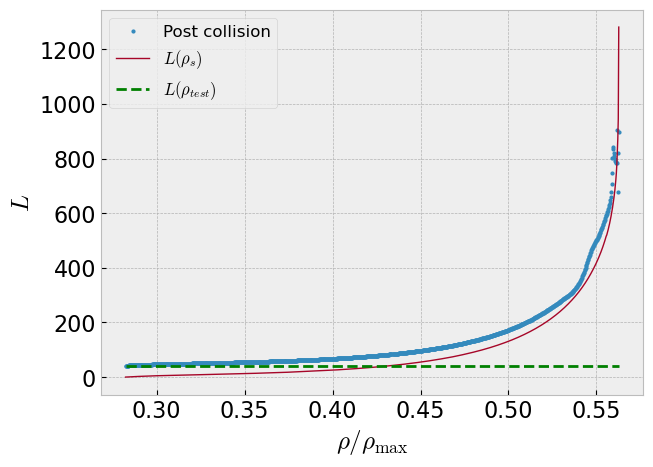

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, L_tau_5, ".", label="Post collision", ms=4)
ax.plot(rhos_to_test/rho_max, L_test, label=r"$L(\rho_s)$", lw=1)
ax.hlines(L_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, color="green", ls="--", label=r"$L(\rho_{test})$")

ax.legend(fontsize=12, loc='best')

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")

#plt.ylim(0, 1000)
plt.ylabel(r"$L$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.legend(fontsize=12)
plt.savefig("Img/Collisions/L_coll.pdf", dpi=300, bbox_inches = "tight")
plt.show()

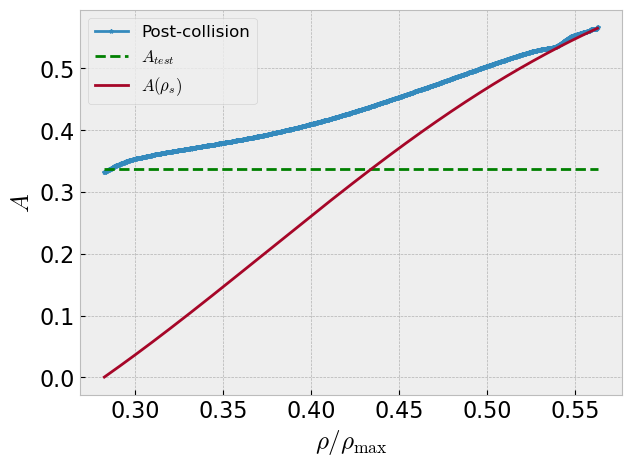

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, A_tau_5/rho_max, "*-", ms=3, label="Post-collision")
plt.hlines(A_t/rho_max, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$A_{test}$")
ax.plot(rhos_to_test/rho_max, np.array(A_test)/rho_max, label=r"$A(\rho_s)$")
#plt.plot(rhos_to_test/rho_max, s_to_test, label=r"$s(\rho_s)$")
#plt.hlines(s_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")
#plt.vlines(rho_s_test, -5, 8, ls="--", color="green")

plt.legend(fontsize=12)
#plt.ylim(-2.9, 7)
plt.ylabel(r"$A$")
plt.xlabel(r"$\rho/\rho_{\max}$")
#plt.savefig("Img/Collisions/s_coll_polynomial.pdf", dpi=300, bbox_inches = "tight")
plt.savefig("Img/Collisions/A_coll_poly.pdf", dpi=300, bbox_inches = "tight")
plt.show()

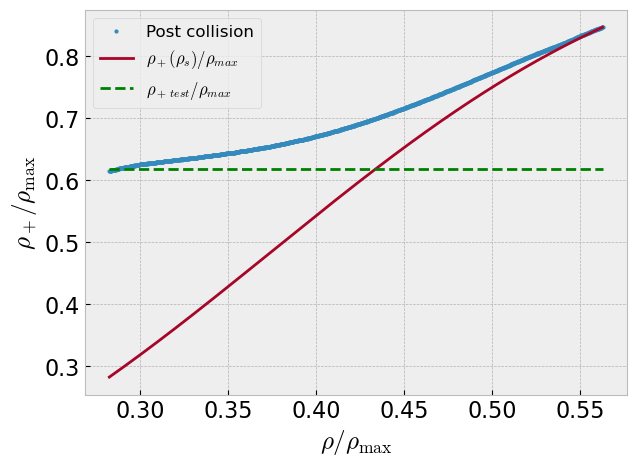

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, np.array(rho_plus_tau_5)/rho_max, ".", label="Post collision", ms=4)
ax.plot(rhos_to_test/rho_max, np.array(rho_plus_test)/rho_max, label=r"$\rho_+(\rho_s)/\rho_{max}$")
ax.hlines(rho_plus_t/rho_max, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, color="green", ls="--", label=r"${\rho_+}_{test}/\rho_{max}$")

ax.legend(fontsize=12, loc='best')

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")

#plt.ylim(0, 1000)
plt.ylabel(r"$\rho_+/\rho_{\max}$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.legend(fontsize=12)
plt.savefig("Img/Collisions/rho_plus_coll_poly.pdf", dpi=300, bbox_inches = "tight")
plt.show()

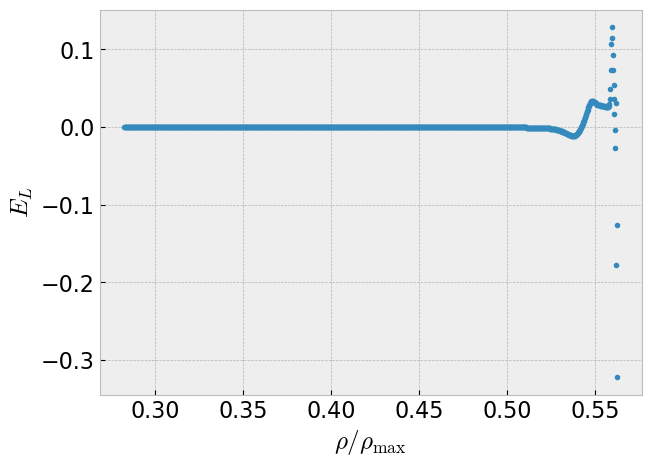

In [15]:
L_total_theo_tau_5 = np.array(L_test) + L_t

errors_L_sum_tau_5 = (L_tau_5 - L_total_theo_tau_5)/np.max(L_total_theo_tau_5)

plt.plot(rhos_to_test/rho_max, errors_L_sum_tau_5, ".")

plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$E_L$")
plt.savefig("Img/Collisions/Error_sum_L_tau_5.pdf", dpi=300, bbox_inches = "tight")
plt.show()

## $\tau = 1$

In [43]:
tau = 1
A_test = []
L_test = []
rho_min_test = []
rho_plus_test = []

for rho_test in rhos_to_test:

    if rho_test/rho_max < 0.512:
        tf = 50

    elif 0.512 < rho_test/rho_max and rho_test/rho_max < 0.559:
        tf = 150

    else:
        tf = 300
    
    x_minus, x_plus, sol_v, sol_v_eta, m, s, values_v = jam_values(tau, rho_test/rho_max, tf, v_minus=v_minus, print_pars=False)

    v_plus_col = values_v["v_plus"]
    
    rho_min_col = 1/v_minus
    rho_plus_col = 1/v_plus_col
    
    L = x_minus - x_plus #get_L(v_plus_col, v_minus, s, m, tau, vs)
    A = rho_plus_col - rho_min_col

    L_test += [L]
    A_test += [A]
    rho_min_test += [rho_min_col]
    rho_plus_test += [rho_plus_col]


/Users/sebatapia/Desktop/Jamiton/Test_and_results/../Functions.py:19: RuntimeWarning: invalid value encountered in power
  output =  beta * gamma * (rho /(rho_max - rho))**(gamma-1) * rho_max / ((rho_max - rho)**2)


In [44]:
tau = 1
tf_test = 20
rhos_to_test, rho_s_test, v_minus = get_rho_s_tests()
rho_s_test = rho_s_test/rho_max

# Test Jamiton
x_minus_t, x_plus_t, sol_v_t, sol_v_eta_t, m_t, s_t, values_v_t = jam_values(tau, rho_s_test, tf_test, v_minus=v_minus, print_pars=False)
v_plus_t = values_v_t["v_plus"]

rho_min_t = 1/v_minus
rho_plus_t = 1/v_plus_t

L_t = x_minus_t - x_plus_t #get_L(v_plus_t, v_minus, s_t, m_t, tau, 1/rho_s_test)
A_t = rho_plus_t - rho_min_t

In [45]:
dx = 2**(-5)
total_cols = 4
total = int(len(rhos_to_test)/4)

rhos = []
ys = []

tau_1_path = base_path + "tau_1_new/"

for n in range(total_cols):
    rhos_cols = []
    ys_cols = []

    col_folder = tau_1_path + "Colls_{}_tau_1/".format(n)
    rho_folder = col_folder + "rho/"
    y_folder = col_folder + "y/"
    rhos_collided = rhos_to_test[n*total:(n+1)*total]

    for rho_s in rhos_collided:
        rho_filename = rho_folder + "rho_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
        rho_file = gzip.GzipFile(rho_filename, "r")
        rho = np.load(rho_file)

        y_filename = y_folder + "y_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
        y_file = gzip.GzipFile(y_filename, "r")
        y = np.load(y_file)
        
        rhos_cols += [rho]
        ys_cols += [y]
    rhos += [rhos_cols]
    ys += [ys_cols]


In [46]:
rhos_array = np.full(1024, fill_value=None)
ys_array = np.full(1024, fill_value=None)

for j in range(4):
    for n in range(len(rhos[j])):
        rhos_array[n+j*256] = rhos[j][n]
        ys_array[n+j*256] = ys[j][n]

In [47]:
tau = 1
vs_tau_1 = []
s_tau_1 = []
rho_min_tau_1 = []
rho_plus_tau_1 = []
L_tau_1 = []
A_tau_1 = []

for j in range(len(rhos_array)):
    rho = rhos_array[j]
    y = ys_array[j]
    s, m = get_s_least_squares(rho, y)

    rho_min = np.min(rho)
    rho_plus = np.max(rho)

    v_min_col = 1/rho_min
    v_plus_col = 1/rho_plus
    vs = get_v_s(m, s, v_plus_col)
    
    L_col = get_L(v_plus_col, v_min_col, s, m, tau, vs)
    A_col = rho_plus - rho_min

    vs_tau_1 += [vs]
    s_tau_1 += [s]
    rho_min_tau_1 += [rho_min]
    rho_plus_tau_1 += [rho_plus]
    L_tau_1 += [L_col]
    A_tau_1 += [A_col]

vs_tau_1 = np.array(vs_tau_1)
s_tau_1 = np.array(s_tau_1)
rho_min_tau_1 = np.array(rho_min_tau_1)
rho_plus_tau_1 = np.array(rho_plus_tau_1)
L_tau_1 = np.array(L_tau_1)
A_tau_1 = np.array(A_tau_1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


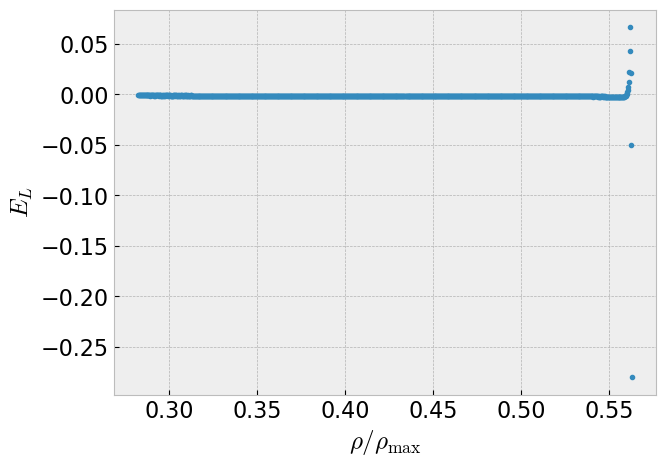

In [48]:
L_total_theo_tau_1 = np.array(L_test) + L_t

errors_L_sum_tau_1 = (L_tau_1 - L_total_theo_tau_1)/np.max(L_total_theo_tau_1)

plt.plot(rhos_to_test/rho_max, errors_L_sum_tau_1, ".")

plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$E_L$")
plt.savefig("Img/Collisions/Error_sum_L_tau_1.pdf", dpi=300, bbox_inches = "tight")
plt.show()

## $\tau = 10$

In [49]:
tau = 10
A_test = []
L_test = []
rho_min_test = []
rho_plus_test = []

for rho_test in rhos_to_test:

    if rho_test/rho_max < 0.542:
        tf = 700

    elif 0.542 < rho_test/rho_max and rho_test/rho_max < 0.559:
        tf = 1300

    else:
        tf = 2600

    x_minus, x_plus, sol_v, sol_v_eta, m, s, values_v = jam_values(tau, rho_test/rho_max, tf, v_minus=v_minus, print_pars=False)
    
    v_plus_col = values_v["v_plus"]
    
    rho_min_col = 1/v_minus
    rho_plus_col = 1/v_plus_col #values_rho["rho_plus"]
    
    L = x_minus - x_plus #get_L(v_plus_col, v_minus, s, m, tau, vs)
    A = rho_plus_col - rho_min_col

    L_test += [L]
    A_test += [A]
    rho_min_test += [rho_min_col]
    rho_plus_test += [rho_plus_col]


/Users/sebatapia/Desktop/Jamiton/Test_and_results/../Functions.py:19: RuntimeWarning: invalid value encountered in power
  output =  beta * gamma * (rho /(rho_max - rho))**(gamma-1) * rho_max / ((rho_max - rho)**2)


In [50]:
tau = 10
tf_test = 150
rhos_to_test, rho_s_test, v_minus = get_rho_s_tests()
rho_s_test = rho_s_test/rho_max

# Test Jamiton
x_minus_t, x_plus_t, sol_v_t, sol_v_eta_t, m_t, s_t, values_v_t = jam_values(tau, rho_s_test, tf_test, v_minus=v_minus, print_pars=False)
v_plus_t = values_v_t["v_plus"]

rho_min_t = 1/v_minus
rho_plus_t = 1/v_plus_t

L_t = x_minus_t - x_plus_t #get_L(v_plus_t, v_minus, s_t, m_t, tau, 1/rho_s_test)
A_t = rho_plus_t - rho_min_t

In [51]:
dx = 2**(-4)
total_cols = 4
total = int(len(rhos_to_test)/4)

rhos = []
ys = []

tau_10_path = base_path + "tau_10_new/"

for n in range(total_cols):
    rhos_cols = []
    ys_cols = []

    col_folder = tau_10_path + "Colls_{}_tau_10/".format(n)
    rho_folder = col_folder + "rho/"
    y_folder = col_folder + "y/"
    rhos_collided = rhos_to_test[n*total:(n+1)*total]

    for rho_s in rhos_collided:
        rho_filename = rho_folder + "rho_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
        rho_file = gzip.GzipFile(rho_filename, "r")
        rho = np.load(rho_file)

        y_filename = y_folder + "y_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
        y_file = gzip.GzipFile(y_filename, "r")
        y = np.load(y_file)
        
        rhos_cols += [rho]
        ys_cols += [y]
    rhos += [rhos_cols]
    ys += [ys_cols]
#rhos = np.array(rhos)
#ys = np.array(ys)

In [52]:
rhos_array = np.full(1024, fill_value=None)
ys_array = np.full(1024, fill_value=None)

for j in range(4):
    for n in range(len(rhos[j])):
        rhos_array[n+j*256] = rhos[j][n]
        ys_array[n+j*256] = ys[j][n]

In [53]:
tau = 10
vs_tau_10 = []
s_tau_10 = []
rho_min_tau_10 = []
rho_plus_tau_10 = []
L_tau_10 = []
A_tau_10 = []

for j in range(len(rhos_array)):
    rho = rhos_array[j]
    y = ys_array[j]
    s, m = get_s_least_squares(rho, y)

    rho_min = np.min(rho)
    rho_plus = np.max(rho)

    v_min_col = 1/rho_min
    v_plus_col = 1/rho_plus
    vs = get_v_s(m, s, v_plus_col)
    L_col = get_L(v_plus_col, v_min_col, s, m, tau, vs)
    A_col = rho_plus - rho_min

    vs_tau_10 += [vs]
    s_tau_10 += [s]
    rho_min_tau_10 += [rho_min]
    rho_plus_tau_10 += [rho_plus]
    L_tau_10 += [L_col]
    A_tau_10 += [A_col]

vs_tau_10 = np.array(vs_tau_10)
s_tau_10 = np.array(s_tau_10)
rho_min_tau_10 = np.array(rho_min_tau_10)
rho_plus_tau_10 = np.array(rho_plus_tau_10)
L_tau_10 = np.array(L_tau_10)
A_tau_10 = np.array(A_tau_10)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_58011/4132445854.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  L_2 = tau * quad(to_integ, vs+eps, v_min, points=[vs])[0]


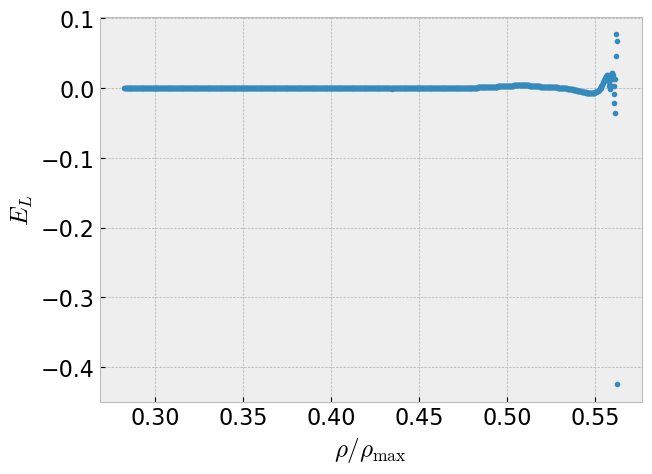

In [54]:
L_total_theo_tau_10 = np.array(L_test) + L_t

errors_L_sum_tau_10 = (L_tau_10 - L_total_theo_tau_10)/np.max(L_total_theo_tau_10)

plt.plot(rhos_to_test/rho_max, errors_L_sum_tau_10, ".")

plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$E_L$")
plt.savefig("Img/Collisions/Error_sum_L_tau_10.pdf", dpi=300, bbox_inches = "tight")
plt.show()

## $\tau$ comparative

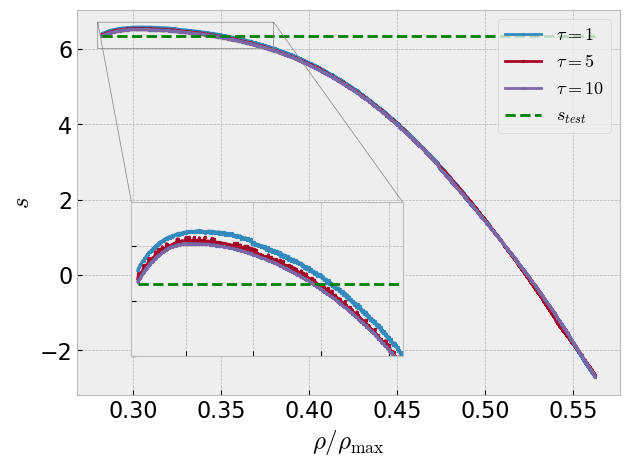

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, s_tau_1, "*-", ms=2, label=r"$\tau = 1$")
ax.plot(rhos_to_test/rho_max, s_tau_5, "*-", ms=2, label=r"$\tau = 5$")
ax.plot(rhos_to_test/rho_max, s_tau_10, "*-", ms=2, label=r"$\tau = 10$")
ax.hlines(s_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")

# Zoom métodos 2, 3 y 4
ax_mini = ax.inset_axes([0.1, 0.1, 0.5, 0.4])
ax_mini.plot(rhos_to_test/rho_max, s_tau_1, "*-", ms=2)
ax_mini.plot(rhos_to_test/rho_max, s_tau_5, "*-", ms=2)
ax_mini.plot(rhos_to_test/rho_max, s_tau_10, "*-", ms=2)
ax_mini.hlines(s_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")

ax_mini.set_ylim(6, 6.7)
ax_mini.set_xlim(0.28, 0.38)
#ax_mini.grid()

ax.legend(fontsize=13)

ax_mini.set_xticklabels('')
ax_mini.set_yticklabels('')

plt.ylabel(r"$s$")
plt.xlabel(r"$\rho/\rho_{\max}$")

ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")
#plt.ylim(-2.9, 7)
plt.savefig("Img/Collisions/compt_taus_s.pdf", dpi=300, bbox_inches = "tight")
plt.show()

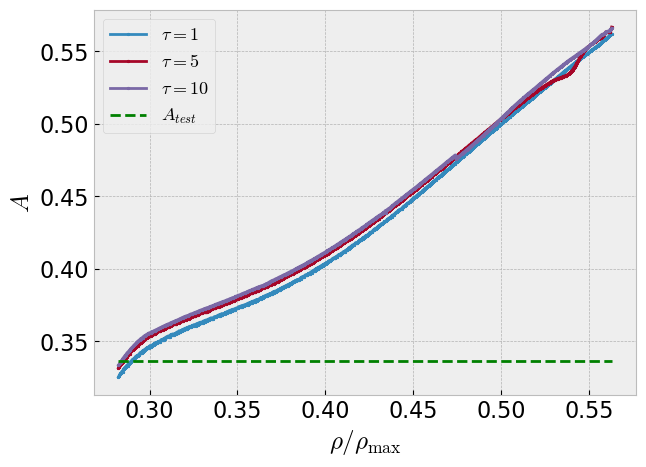

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, A_tau_1/rho_max, "*-", ms=2, label=r"$\tau = 1$")
ax.plot(rhos_to_test/rho_max, A_tau_5/rho_max, "*-", ms=2, label=r"$\tau = 5$")
ax.plot(rhos_to_test/rho_max, A_tau_10/rho_max, "*-", ms=2, label=r"$\tau = 10$")
ax.hlines(A_t/rho_max, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$A_{test}$")

# Zoom métodos 2, 3 y 4
#ax_mini = ax.inset_axes([0.1, 0.1, 0.5, 0.4])
#ax_mini.plot(rhos_to_test/rho_max, s_tau_1, "*-", ms=2)
#ax_mini.plot(rhos_to_test/rho_max, s_tau_5, "*-", ms=2)
#ax_mini.plot(rhos_to_test/rho_max, s_tau_10, "*-", ms=2)

#ax_mini.set_ylim(6.3, 6.7)
#ax_mini.set_xlim(0.3, 0.35)
#ax_mini.grid()

ax.legend(fontsize=13)

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

plt.ylabel(r"$A$")
plt.xlabel(r"$\rho/\rho_{\max}$")

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")
#plt.ylim(-2.9, 7)
plt.savefig("Img/Collisions/compt_taus_A.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [57]:
s, m = get_s_least_squares(rho, y)

rho_min = np.min(rhos_array[-1])
rho_plus = np.max(rhos_array[-1])

v_min_col = 1/rho_min
v_plus_col = 1/rho_plus

def to_integ(v):
        num = r_prime(v, m)
        den = w_v(v, m, s)
        return v * num/den

total = 100_001
if s < -2.603016951915652:
    total = 10_000

v_to_int = np.linspace(v_plus_col, v_min_col, 100_001)

dx = np.abs(v_to_int[1] - v_to_int[0])

L_col = 10 * simpson(to_integ(v_to_int), x=v_to_int, dx=dx)
L_tau_10[-1] = L_col

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


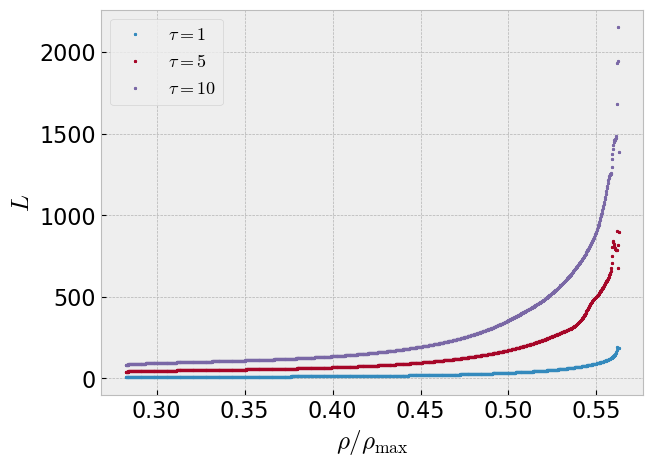

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, L_tau_1, "*", ms=2, label=r"$\tau = 1$")
ax.plot(rhos_to_test/rho_max, L_tau_5, "*", ms=2, label=r"$\tau = 5$")
ax.plot(rhos_to_test/rho_max, L_tau_10, "*", ms=2, label=r"$\tau = 10$")

# Zoom métodos 2, 3 y 4
#ax_mini = ax.inset_axes([0.1, 0.1, 0.5, 0.4])
#ax_mini.plot(rhos_to_test/rho_max, s_tau_1, "*-", ms=2)
#ax_mini.plot(rhos_to_test/rho_max, s_tau_5, "*-", ms=2)
#ax_mini.plot(rhos_to_test/rho_max, s_tau_10, "*-", ms=2)

#ax_mini.set_ylim(6.3, 6.7)
#ax_mini.set_xlim(0.3, 0.35)
#ax_mini.grid()

ax.legend(fontsize=13)

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

plt.ylabel(r"$L$")
plt.xlabel(r"$\rho/\rho_{\max}$")

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")
#plt.ylim(-2.9, 7)
plt.savefig("Img/Collisions/compt_taus_L.pdf", dpi=300, bbox_inches = "tight")
plt.show()

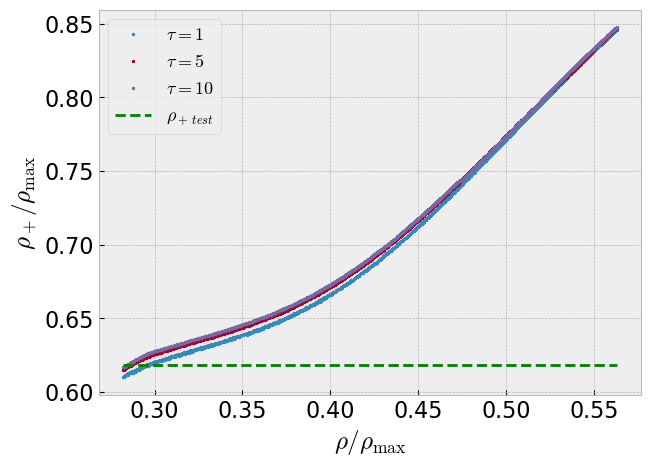

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, rho_plus_tau_1/rho_max, "*", ms=2, label=r"$\tau = 1$")
ax.plot(rhos_to_test/rho_max, rho_plus_tau_5/rho_max, "*", ms=2, label=r"$\tau = 5$")
ax.plot(rhos_to_test/rho_max, rho_plus_tau_10/rho_max, "*", ms=2, label=r"$\tau = 10$")

ax.hlines(rho_plus_t/rho_max, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"${\rho_+}_{test}$")

# Zoom métodos 2, 3 y 4
#ax_mini = ax.inset_axes([0.1, 0.1, 0.5, 0.4])
#ax_mini.plot(rhos_to_test/rho_max, s_tau_1, "*-", ms=2)
#ax_mini.plot(rhos_to_test/rho_max, s_tau_5, "*-", ms=2)
#ax_mini.plot(rhos_to_test/rho_max, s_tau_10, "*-", ms=2)

#ax_mini.set_ylim(6.3, 6.7)
#ax_mini.set_xlim(0.3, 0.35)
#ax_mini.grid()

ax.legend(fontsize=13)

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

plt.ylabel(r"$\rho_+/{\rho_{\max}}$")
plt.xlabel(r"$\rho/\rho_{\max}$")

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")
#plt.ylim(-2.9, 7)
plt.savefig("Img/Collisions/compt_taus_rho_plus.pdf", dpi=300, bbox_inches = "tight")
plt.show()

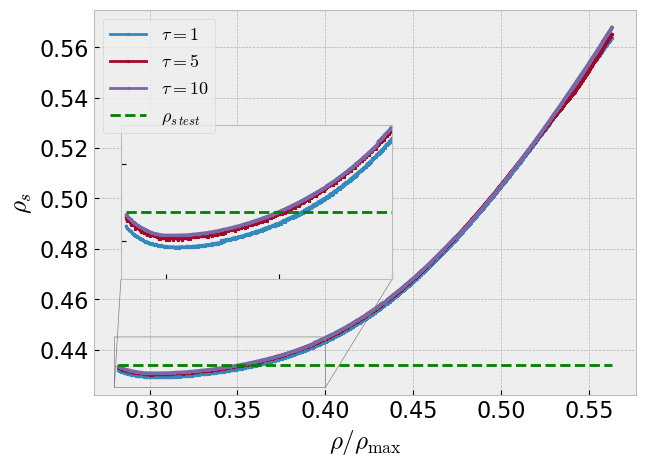

In [60]:
rho_s_tau_1 = 1/(np.array(vs_tau_1)*rho_max)
rho_s_tau_5 = 1/(np.array(vs_tau_5)*rho_max)
rho_s_tau_10 = 1/(np.array(vs_tau_10)*rho_max)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, rho_s_tau_1, "*-", ms=2, label=r"$\tau = 1$")
ax.plot(rhos_to_test/rho_max, rho_s_tau_5, "*-", ms=2, label=r"$\tau = 5$")
ax.plot(rhos_to_test/rho_max, rho_s_tau_10, "*-", ms=2, label=r"$\tau = 10$")
ax.hlines(rho_s_test, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"${\rho_s}_{test}$")
#ax.hlines(s_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")

# Zoom métodos 2, 3 y 4
ax_mini = ax.inset_axes([0.05, 0.3, 0.5, 0.4])
ax_mini.plot(rhos_to_test/rho_max, rho_s_tau_1, "*-", ms=2)
ax_mini.plot(rhos_to_test/rho_max, rho_s_tau_5, "*-", ms=2)
ax_mini.plot(rhos_to_test/rho_max, rho_s_tau_10, "*-", ms=2)
ax_mini.hlines(rho_s_test, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"${\rho_s}_{test}$")
#ax_mini.hlines(s_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")

ax_mini.set_ylim(0.425, 0.445)
ax_mini.set_xlim(0.28, 0.4)
ax_mini.grid()

ax.legend(fontsize=13)

ax_mini.set_xticklabels('')
ax_mini.set_yticklabels('')

plt.ylabel(r"$\rho_s$")
plt.xlabel(r"$\rho/\rho_{\max}$")

ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")
#plt.ylim(-2.9, 7)
plt.savefig("Img/Collisions/compt_taus_rho_s.pdf", dpi=300, bbox_inches = "tight")
plt.show()

# Different $\Delta x$

In [16]:
dxs = [2**(-j) for j in range(4)]
total_cols = 4
total = int(len(rhos_to_test)/4)

rhos_dx = []
ys_dx = []

dxs_path = base_path + "tau_5_Ns/"
dxs_folders = ["dx_2_0", "dx_2_-1", "dx_2_-2", "dx_2_-3"]

for j in range(len(dxs)):
    path = dxs_path + dxs_folders[j] + "/"
    rho_dx_list = []
    y_dx_list = []

    for n in range(total_cols):
        col_folder = path + "Colls_{}_tau_5/".format(n)
        rho_folder = col_folder + "rho/"
        y_folder = col_folder + "y/"
        rhos_collided = rhos_to_test[n*total:(n+1)*total]

        for rho_s in rhos_collided:
            rho_filename = rho_folder + "rho_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
            rho_file = gzip.GzipFile(rho_filename, "r")
            rho = np.load(rho_file)

            y_filename = y_folder + "y_coll_{}.npy.gz".format(round(rho_s/rho_max, 6))
            y_file = gzip.GzipFile(y_filename, "r")
            y = np.load(y_file)
            #u = y/rho - h(rho)

            rho_dx_list += [rho]
            y_dx_list += [y]

    rhos_dx += [rho_dx_list]
    ys_dx += [y_dx_list]

In [17]:
# dx = 2^{0}
tau = 5

vs_dx_0 = []
s_dx_0 = []
rho_min_dx_0 = []
rho_plus_dx_0 = []
L_dx_0 = []
A_dx_0 = []

for j in range(len(rhos_dx[0])):
    rho = rhos_dx[0][j]
    y = ys_dx[0][j]
    s, m = get_s_least_squares(rho, y)

    rho_min = np.min(rho)
    rho_plus = np.max(rho)

    v_min_col = 1/(rho_min)
    v_plus_col = 1/(rho_plus)

    vs = get_v_s(m, s, v_plus_col)
    L_col = get_L(v_plus_col, v_min_col, s, m, tau, vs)
    A_col = rho_plus - rho_min

    vs_dx_0 += [vs]
    s_dx_0 += [s]
    rho_min_dx_0 += [rho_min]
    rho_plus_dx_0 += [rho_plus]
    L_dx_0 += [L_col]
    A_dx_0 += [A_col]

vs_dx_0 = np.array(vs_dx_0)
s_dx_0 = np.array(s_dx_0)
rho_min_dx_0 = np.array(rho_min_dx_0)
rho_plus_dx_0 = np.array(rho_plus_dx_0)
L_dx_0 = np.array(L_dx_0)
A_dx_0 = np.array(A_dx_0)

# dx = 2^{-1}
vs_dx_1 = []
s_dx_1 = []
rho_min_dx_1 = []
rho_plus_dx_1 = []
L_dx_1 = []
A_dx_1 = []

for j in range(len(rhos_dx[1])):
    rho = rhos_dx[1][j]
    y = ys_dx[1][j]
    s, m = get_s_least_squares(rho, y)

    rho_min = np.min(rho)
    rho_plus = np.max(rho)

    v_min_col = 1/(rho_min)
    v_plus_col = 1/(rho_plus)

    vs = get_v_s(m, s, v_plus_col)
    L_col = get_L(v_plus_col, v_min_col, s, m, tau, vs)
    A_col = rho_plus - rho_min

    vs_dx_1 += [vs]
    s_dx_1 += [s]
    rho_min_dx_1 += [rho_min]
    rho_plus_dx_1 += [rho_plus]
    L_dx_1 += [L_col]
    A_dx_1 += [A_col]

vs_dx_1 = np.array(vs_dx_1)
s_dx_1 = np.array(s_dx_1)
rho_min_dx_1 = np.array(rho_min_dx_1)
rho_plus_dx_1 = np.array(rho_plus_dx_1)
L_dx_1 = np.array(L_dx_1)
A_dx_1 = np.array(A_dx_1)

# dx = 2^{-2}
vs_dx_2 = []
s_dx_2 = []
rho_min_dx_2 = []
rho_plus_dx_2 = []
L_dx_2 = []
A_dx_2 = []

for j in range(len(rhos_dx[2])):
    rho = rhos_dx[2][j]
    y = ys_dx[2][j]
    s, m = get_s_least_squares(rho, y)

    rho_min = np.min(rho)
    rho_plus = np.max(rho)

    v_min_col = 1/(rho_min)
    v_plus_col = 1/(rho_plus)

    vs = get_v_s(m, s, v_plus_col)    
    L_col = get_L(v_plus_col, v_min_col, s, m, tau, vs)
    A_col = rho_plus - rho_min

    vs_dx_2 += [vs]
    s_dx_2 += [s]
    rho_min_dx_2 += [rho_min]
    rho_plus_dx_2 += [rho_plus]
    L_dx_2 += [L_col]
    A_dx_2 += [A_col]

vs_dx_2 = np.array(vs_dx_2)
s_dx_2 = np.array(s_dx_2)
rho_min_dx_2 = np.array(rho_min_dx_2)
rho_plus_dx_2 = np.array(rho_plus_dx_2)
L_dx_2 = np.array(L_dx_2)
A_dx_2 = np.array(A_dx_2)

# dx = 2^{-3}
vs_dx_3 = []
s_dx_3 = []
rho_min_dx_3 = []
rho_plus_dx_3 = []
L_dx_3 = []
A_dx_3 = []

for j in range(len(rhos_dx[3])):
    rho = rhos_dx[3][j]
    y = ys_dx[3][j]
    s, m = get_s_least_squares(rho, y)

    rho_min = np.min(rho)
    rho_plus = np.max(rho)

    v_min_col = 1/(rho_min)
    v_plus_col = 1/(rho_plus)

    vs = get_v_s(m, s, v_plus_col)
    L_col = get_L(v_plus_col, v_min_col, s, m, tau, vs)
    A_col = rho_plus - rho_min

    vs_dx_3 += [vs]
    s_dx_3 += [s]
    rho_min_dx_3 += [rho_min]
    rho_plus_dx_3 += [rho_plus]
    L_dx_3 += [L_col]
    A_dx_3 += [A_col]

vs_dx_3 = np.array(vs_dx_3)
s_dx_3 = np.array(s_dx_3)
rho_min_dx_3 = np.array(rho_min_dx_3)
rho_plus_dx_3 = np.array(rho_plus_dx_3)
L_dx_3 = np.array(L_dx_3)
A_dx_3 = np.array(A_dx_3)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_58011/4132445854.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  L_2 = tau * quad(to_integ, vs+eps, v_min, points=[vs])[0]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


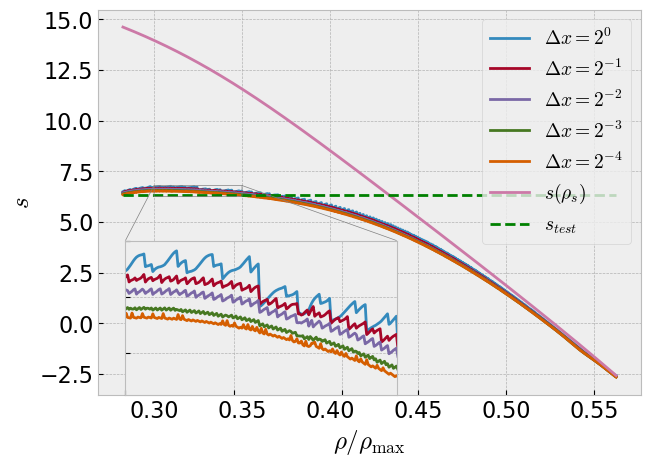

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, s_dx_0, label=r"$\Delta x= 2^{0}$")
ax.plot(rhos_to_test/rho_max, s_dx_1, label=r"$\Delta x= 2^{-1}$")
ax.plot(rhos_to_test/rho_max, s_dx_2, label=r"$\Delta x= 2^{-2}$")
ax.plot(rhos_to_test/rho_max, s_dx_3, label=r"$\Delta x= 2^{-3}$")
ax.plot(rhos_to_test/rho_max, s_tau_5, label=r"$\Delta x= 2^{-4}$")

# Zoom métodos 2, 3 y 4
ax_mini = ax.inset_axes([0.05, 0, 0.5, 0.4])
ax_mini.plot(rhos_to_test/rho_max, s_dx_0, label=r"$\Delta x= 2^{0}$")
ax_mini.plot(rhos_to_test/rho_max, s_dx_1, label=r"$\Delta x= 2^{-1}$")
ax_mini.plot(rhos_to_test/rho_max, s_dx_2, label=r"$\Delta x= 2^{-2}$")
ax_mini.plot(rhos_to_test/rho_max, s_dx_3, label=r"$\Delta x= 2^{-3}$")
ax_mini.plot(rhos_to_test/rho_max, s_tau_5, label=r"$\Delta x= 2^{-4}$")
plt.plot(rhos_to_test/rho_max, s_to_test, label=r"$s(\rho_s)$")
plt.hlines(s_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")

ax_mini.set_ylim(6.25, 6.8)
ax_mini.set_xlim(0.3, 0.35)
#ax_mini.grid()

ax.legend(fontsize=12, loc='best')

ax_mini.set_xticklabels('')
ax_mini.set_yticklabels('')

ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")

plt.ylabel(r"$s$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.legend(fontsize=14)
plt.savefig("Img/Collisions/s_coll_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

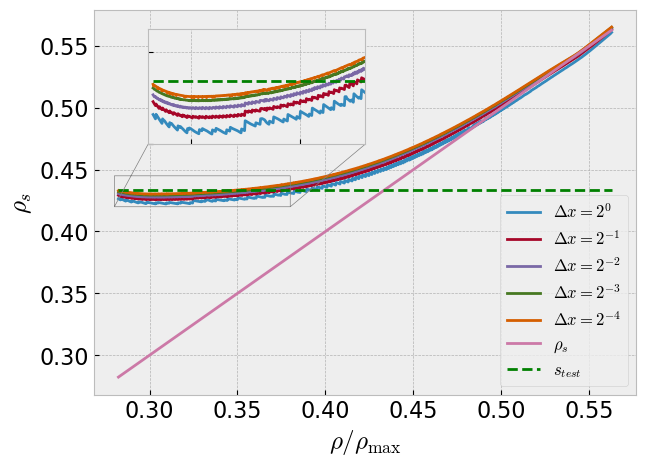

In [19]:
rhos_dx_0 = 1/(vs_dx_0*rho_max)
rhos_dx_1 = 1/(vs_dx_1*rho_max)
rhos_dx_2 = 1/(vs_dx_2*rho_max)
rhos_dx_3 = 1/(vs_dx_3*rho_max)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, rhos_dx_0, label=r"$\Delta x= 2^{0}$")
ax.plot(rhos_to_test/rho_max, rhos_dx_1, label=r"$\Delta x= 2^{-1}$")
ax.plot(rhos_to_test/rho_max, rhos_dx_2, label=r"$\Delta x= 2^{-2}$")
ax.plot(rhos_to_test/rho_max, rhos_dx_3, label=r"$\Delta x= 2^{-3}$")
ax.plot(rhos_to_test/rho_max, rho_s_tau_5, label=r"$\Delta x= 2^{-4}$")
ax.plot(rhos_to_test/rho_max, rhos_to_test/rho_max, label=r"$\rho_s$")
ax.hlines(rho_s_test, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")
#plt.plot(rhos_to_test/rho_max, rhos_to_test/rho_max, label=r"$\rho_s$")

# Zoom métodos 2, 3 y 4
ax_mini = ax.inset_axes([0.1, 0.65, 0.4, 0.3])
ax_mini.plot(rhos_to_test/rho_max, rhos_dx_0, label=r"$\Delta x= 2^{0}$")
ax_mini.plot(rhos_to_test/rho_max, rhos_dx_1, label=r"$\Delta x= 2^{-1}$")
ax_mini.plot(rhos_to_test/rho_max, rhos_dx_2, label=r"$\Delta x= 2^{-2}$")
ax_mini.plot(rhos_to_test/rho_max, rhos_dx_3, label=r"$\Delta x= 2^{-3}$")
ax_mini.plot(rhos_to_test/rho_max, rho_s_tau_5, label=r"$\Delta x= 2^{-4}$")
ax_mini.plot(rhos_to_test/rho_max, rhos_to_test/rho_max, label=r"$\rho_s$")
#plt.plot(rhos_to_test/rho_max, rhos_to_test/rho_max, label=r"$\rho_s$")
ax_mini.hlines(rho_s_test, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, ls="--", color="green", label=r"$s_{test}$")

ax_mini.set_ylim(0.42, 0.445)
ax_mini.set_xlim(0.28, 0.38)
#ax_mini.grid()


ax_mini.set_xticklabels('')
ax_mini.set_yticklabels('')

ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")

ax.legend(fontsize=12, loc="lower right")

plt.ylabel(r"$\rho_s$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.savefig("Img/Collisions/rhos_coll_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

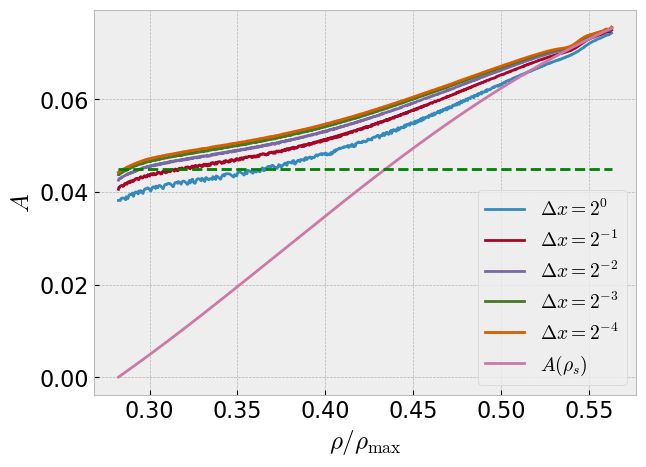

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, A_dx_0, label=r"$\Delta x= 2^{0}$")
ax.plot(rhos_to_test/rho_max, A_dx_1, label=r"$\Delta x= 2^{-1}$")
ax.plot(rhos_to_test/rho_max, A_dx_2, label=r"$\Delta x= 2^{-2}$")
ax.plot(rhos_to_test/rho_max, A_dx_3, label=r"$\Delta x= 2^{-3}$")
ax.plot(rhos_to_test/rho_max, A_tau_5, label=r"$\Delta x= 2^{-4}$")
ax.plot(rhos_to_test/rho_max, A_test, label=r"$A(\rho_s)$")
ax.hlines(A_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, color="green", ls="--")

ax.legend(fontsize=12, loc='best')

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")

plt.ylabel(r"$A$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.legend(fontsize=14)
plt.savefig("Img/Collisions/A_coll_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

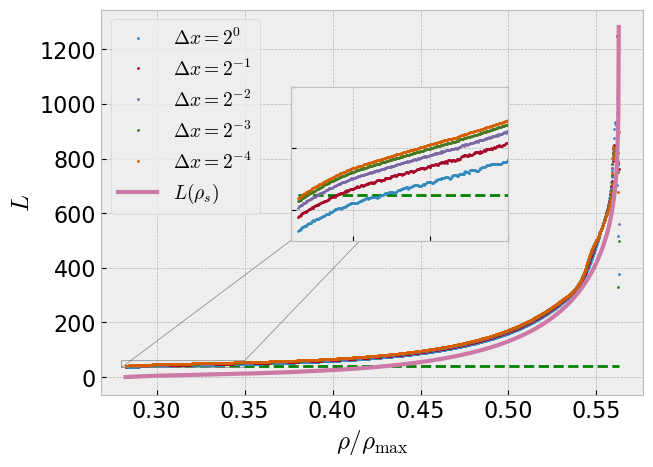

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hlines(L_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, color="green", ls="--")
ax.plot(rhos_to_test/rho_max, L_dx_0, ".", label=r"$\Delta x= 2^{0}$", ms=2)
ax.plot(rhos_to_test/rho_max, L_dx_1, ".", label=r"$\Delta x= 2^{-1}$", ms=2)
ax.plot(rhos_to_test/rho_max, L_dx_2, ".", label=r"$\Delta x= 2^{-2}$", ms=2)
ax.plot(rhos_to_test/rho_max, L_dx_3, ".", label=r"$\Delta x= 2^{-3}$", ms=2)
ax.plot(rhos_to_test/rho_max, L_tau_5, ".", label=r"$\Delta x= 2^{-4}$", ms=2)
ax.plot(rhos_to_test/rho_max, L_test, label=r"$L(\rho_s)$", lw=3)

ax_mini = ax.inset_axes([0.35, 0.4, 0.4, 0.4])
ax_mini.hlines(L_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, color="green", ls="--")
ax_mini.plot(rhos_to_test/rho_max, L_dx_0, ".", label=r"$\Delta x= 2^{0}$", ms=2)
ax_mini.plot(rhos_to_test/rho_max, L_dx_1, ".", label=r"$\Delta x= 2^{-1}$", ms=2)
ax_mini.plot(rhos_to_test/rho_max, L_dx_2, ".", label=r"$\Delta x= 2^{-2}$", ms=2)
ax_mini.plot(rhos_to_test/rho_max, L_dx_3, ".", label=r"$\Delta x= 2^{-3}$", ms=2)
ax_mini.plot(rhos_to_test/rho_max, L_tau_5, ".", label=r"$\Delta x= 2^{-4}$", ms=2)
ax_mini.plot(rhos_to_test/rho_max, L_test, label=r"$L(\rho_s)$", lw=3)

ax_mini.set_ylim(35, 60)
ax_mini.set_xlim(0.28, 0.35)
#ax_mini.grid()


ax_mini.set_xticklabels('')
ax_mini.set_yticklabels('')

ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")


ax.legend(fontsize=12, loc='best')

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")

#plt.ylim(-200, 2700)
plt.ylabel(r"$L$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.legend(fontsize=14)
plt.savefig("Img/Collisions/L_coll_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

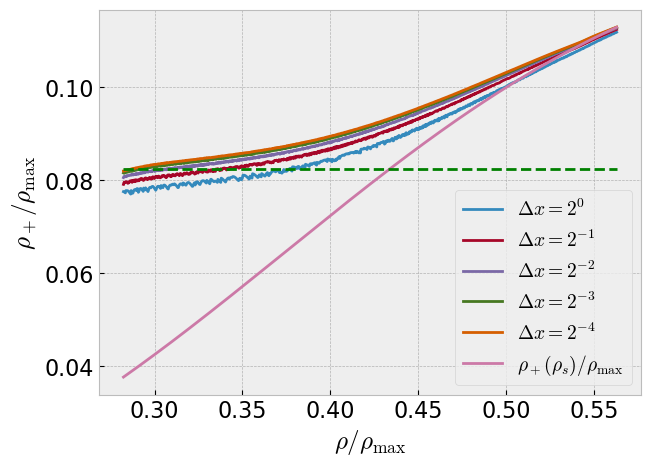

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rhos_to_test/rho_max, rho_plus_dx_0, label=r"$\Delta x= 2^{0}$")
ax.plot(rhos_to_test/rho_max, rho_plus_dx_1, label=r"$\Delta x= 2^{-1}$")
ax.plot(rhos_to_test/rho_max, rho_plus_dx_2, label=r"$\Delta x= 2^{-2}$")
ax.plot(rhos_to_test/rho_max, rho_plus_dx_3, label=r"$\Delta x= 2^{-3}$")
ax.plot(rhos_to_test/rho_max, rho_plus_tau_5, label=r"$\Delta x= 2^{-4}$")
ax.plot(rhos_to_test/rho_max, rho_plus_test, label=r"$\rho_+(\rho_s)/\rho_{\max}$")
ax.hlines(rho_plus_t, rhos_to_test[0]/rho_max, rhos_to_test[-1]/rho_max, color="green", ls="--")

ax.legend(fontsize=12, loc='best')

#ax_mini.set_xticklabels('')
#ax_mini.set_yticklabels('')

#ax.indicate_inset_zoom(ax_mini, alpha=1, label="Zoom")

plt.ylabel(r"$\rho_+/\rho_{\max}$")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.legend(fontsize=14)
plt.savefig("Img/Collisions/rho_plus_coll_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [23]:
errors_s_0 = np.abs(s_dx_0 - s_tau_5)
errors_s_1 = np.abs(s_dx_1 - s_tau_5)
errors_s_2 = np.abs(s_dx_2 - s_tau_5)
errors_s_3 = np.abs(s_dx_3 - s_tau_5)

#errors = np.array([errors_1, errors_2, errors_3])

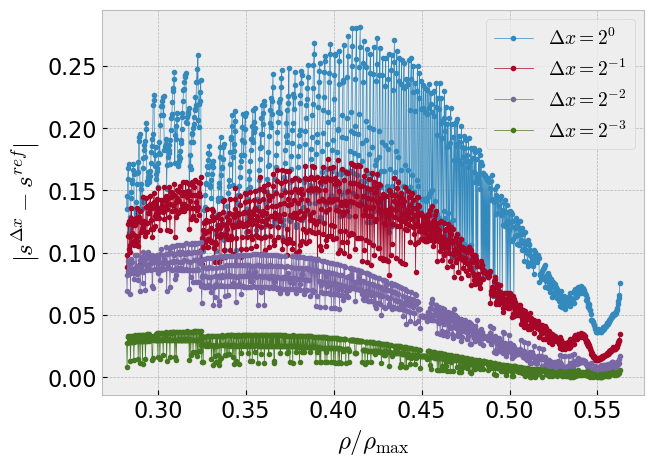

In [24]:
plt.plot(rhos_to_test/rho_max, errors_s_0, ".-", label=r"$\Delta x = 2^{0}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_s_1, ".-", label=r"$\Delta x = 2^{-1}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_s_2, ".-", label=r"$\Delta x = 2^{-2}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_s_3, ".-", label=r"$\Delta x = 2^{-3}$", lw=.5)
#plt.xscale("log")
plt.legend(fontsize=14)
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$|s^{\Delta x} - s^{ref}|$")
plt.savefig("Img/Collisions/s_difs_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [25]:
errors_s_norm_0 = norm(s_dx_0 - s_tau_5, 1)/norm(s_tau_5, 1)
errors_s_norm_1 = norm(s_dx_1 - s_tau_5, 1)/norm(s_tau_5, 1)
errors_s_norm_2 = norm(s_dx_2 - s_tau_5, 1)/norm(s_tau_5, 1)
errors_s_norm_3 = norm(s_dx_3 - s_tau_5, 1)/norm(s_tau_5, 1)

errors_norm = np.array([errors_s_norm_0, errors_s_norm_1, errors_s_norm_2, errors_s_norm_3])

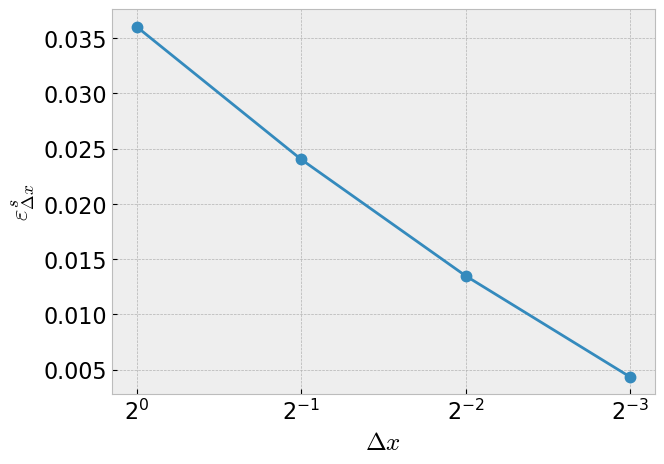

In [26]:
plt.plot(dxs, errors_norm, ".-", ms=15)
#plt.xscale("log")
plt.xscale("log", base=2)
plt.gca().invert_xaxis()

plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$\varepsilon^s_{\Delta x}$")
plt.savefig("Img/Collisions/norm_s_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [27]:
errors_rhos_0 = np.abs(rhos_dx_0 - rho_s_tau_5)/np.abs(rho_s_tau_5)
errors_rhos_1 = np.abs(rhos_dx_1 - rho_s_tau_5)/np.abs(rho_s_tau_5)
errors_rhos_2 = np.abs(rhos_dx_2 - rho_s_tau_5)/np.abs(rho_s_tau_5)
errors_rhos_3 = np.abs(rhos_dx_3 - rho_s_tau_5)/np.abs(rho_s_tau_5)

#errors = np.array([errors_1, errors_2, errors_3])

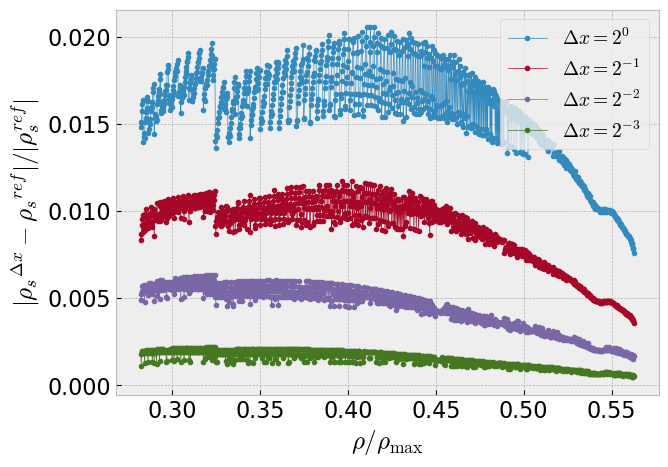

In [28]:
plt.plot(rhos_to_test/rho_max, errors_rhos_0, ".-", label=r"$\Delta x = 2^{0}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_rhos_1, ".-", label=r"$\Delta x = 2^{-1}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_rhos_2, ".-", label=r"$\Delta x = 2^{-2}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_rhos_3, ".-", label=r"$\Delta x = 2^{-3}$", lw=.5)
#plt.xscale("log")
plt.legend(fontsize=14)
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$|{\rho_s}^{\Delta x} - {\rho_s}^{ref}|/|\rho_s^{ref}|$")
plt.savefig("Img/Collisions/rhos_difs_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [29]:
errors_rhos_norm_0 = norm(rhos_dx_0 - rho_s_tau_5, 1)/norm(rho_s_tau_5, 1)
errors_rhos_norm_1 = norm(rhos_dx_1 - rho_s_tau_5, 1)/norm(rho_s_tau_5, 1)
errors_rhos_norm_2 = norm(rhos_dx_2 - rho_s_tau_5, 1)/norm(rho_s_tau_5, 1)
errors_rhos_norm_3 = norm(rhos_dx_3 - rho_s_tau_5, 1)/norm(rho_s_tau_5, 1)

errors_rhos_norm = np.array([errors_rhos_norm_0, errors_rhos_norm_1, errors_rhos_norm_2, errors_rhos_norm_3])

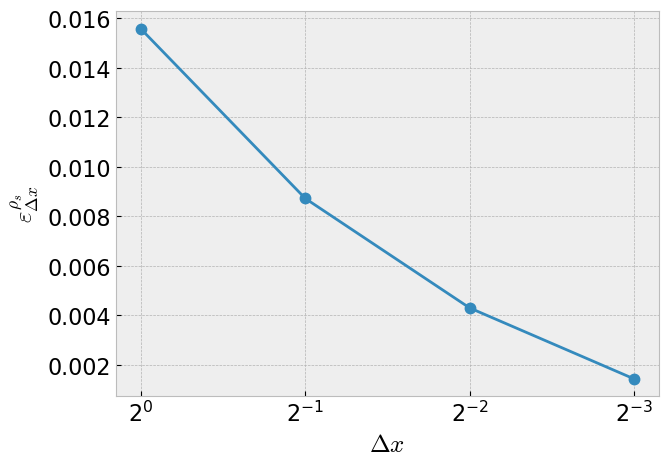

In [30]:
plt.plot(dxs, errors_rhos_norm, ".-", ms=15)
#plt.xscale("log")
plt.xscale("log", base=2)
plt.gca().invert_xaxis()

plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$\varepsilon^{\rho_s}_{\Delta x}$")
plt.savefig("Img/Collisions/norm_rhos_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [31]:
errors_A_0 = np.abs(A_dx_0 - A_tau_5)/np.abs(A_tau_5)
errors_A_1 = np.abs(A_dx_1 - A_tau_5)/np.abs(A_tau_5)
errors_A_2 = np.abs(A_dx_2 - A_tau_5)/np.abs(A_tau_5)
errors_A_3 = np.abs(A_dx_3 - A_tau_5)/np.abs(A_tau_5)

#errors = np.array([errors_1, errors_2, errors_3])

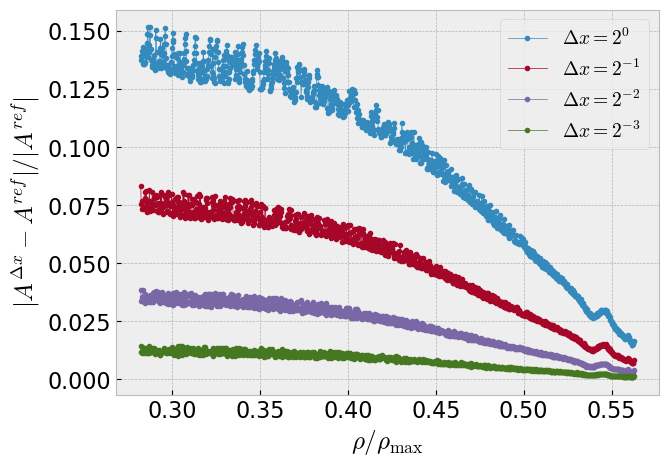

In [32]:
plt.plot(rhos_to_test/rho_max, errors_A_0, ".-", label=r"$\Delta x = 2^{0}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_A_1, ".-", label=r"$\Delta x = 2^{-1}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_A_2, ".-", label=r"$\Delta x = 2^{-2}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_A_3, ".-", label=r"$\Delta x = 2^{-3}$", lw=.5)
#plt.xscale("log")
plt.legend(fontsize=14)
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$|A^{\Delta x} - A^{ref}|/|A^{ref}|$")
plt.savefig("Img/Collisions/A_difs_dxs_.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [33]:
errors_A_norm_0 = norm(A_dx_0 - A_tau_5, 1)/norm(A_tau_5, 1)
errors_A_norm_1 = norm(A_dx_1 - A_tau_5, 1)/norm(A_tau_5, 1)
errors_A_norm_2 = norm(A_dx_2 - A_tau_5, 1)/norm(A_tau_5, 1)
errors_A_norm_3 = norm(A_dx_3 - A_tau_5, 1)/norm(A_tau_5, 1)

errors_A_norm = np.array([errors_A_norm_0, errors_A_norm_1, errors_A_norm_2, errors_A_norm_3])

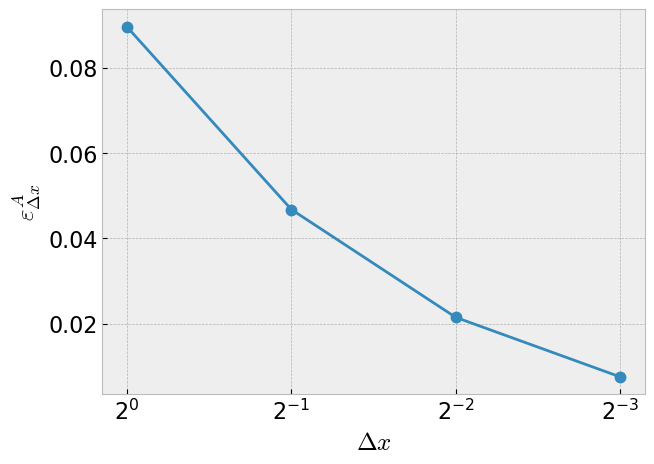

In [34]:
plt.plot(dxs, errors_A_norm, ".-", ms=15)
#plt.xscale("log")
plt.xscale("log", base=2)

plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$\varepsilon^A_{\Delta x}$")
plt.gca().invert_xaxis()
plt.savefig("Img/Collisions/norm_A_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [35]:
errors_L_0 = np.abs(L_dx_0 - L_tau_5)/np.abs(L_tau_5)
errors_L_1 = np.abs(L_dx_1 - L_tau_5)/np.abs(L_tau_5)
errors_L_2 = np.abs(L_dx_2 - L_tau_5)/np.abs(L_tau_5)
errors_L_3 = np.abs(L_dx_3 - L_tau_5)/np.abs(L_tau_5)

errors_L = np.array([errors_L_0, errors_L_1, errors_L_2, errors_L_3])

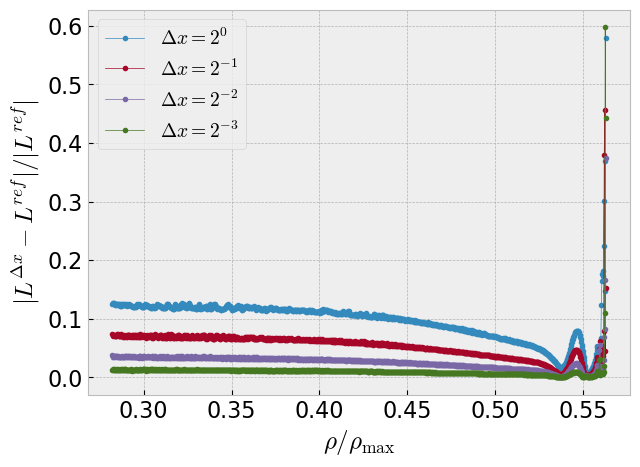

In [36]:
plt.plot(rhos_to_test/rho_max, errors_L_0, ".-", label=r"$\Delta x = 2^{0}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_L_1, ".-", label=r"$\Delta x = 2^{-1}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_L_2, ".-", label=r"$\Delta x = 2^{-2}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_L_3, ".-", label=r"$\Delta x = 2^{-3}$", lw=.5)
#plt.xscale("log")
plt.legend(fontsize=14)
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$|L^{\Delta x} - L^{ref}|/|L^{ref}|$")

#plt.ylim(-0.1, 1000)
plt.savefig("Img/Collisions/L_difs_dxs_.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [37]:
errors_L_norm_0 = norm(L_dx_0 - L_tau_5, 1)/norm(L_tau_5, 1)
errors_L_norm_1 = norm(L_dx_1 - L_tau_5, 1)/norm(L_tau_5, 1)
errors_L_norm_2 = norm(L_dx_2 - L_tau_5, 1)/norm(L_tau_5, 1)
errors_L_norm_3 = norm(L_dx_3 - L_tau_5, 1)/norm(L_tau_5, 1)

errors_L_norm = np.array([errors_L_norm_0, errors_L_norm_1, errors_L_norm_2, errors_L_norm_3])

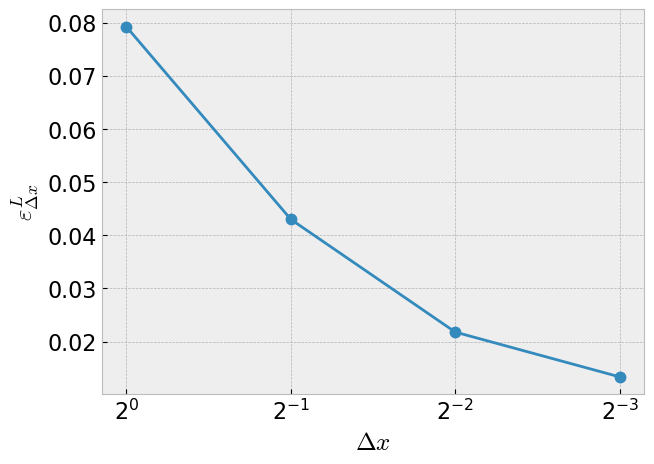

In [38]:
plt.plot(dxs, errors_L_norm, ".-", ms=15)
#plt.xscale("log")
plt.xscale("log", base=2)

plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$\varepsilon^L_{\Delta x}$")
plt.gca().invert_xaxis()
plt.savefig("Img/Collisions/norm_L_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [39]:
errors_rho_plus_0 = np.abs(rho_plus_dx_0 - rho_plus_tau_5)/np.abs(rho_plus_tau_5)
errors_rho_plus_1 = np.abs(rho_plus_dx_1 - rho_plus_tau_5)/np.abs(rho_plus_tau_5)
errors_rho_plus_2 = np.abs(rho_plus_dx_2 - rho_plus_tau_5)/np.abs(rho_plus_tau_5)
errors_rho_plus_3 = np.abs(rho_plus_dx_3 - rho_plus_tau_5)/np.abs(rho_plus_tau_5)

errors_rho_plus = np.array([errors_rho_plus_0, errors_rho_plus_1, errors_rho_plus_2, errors_rho_plus_3])

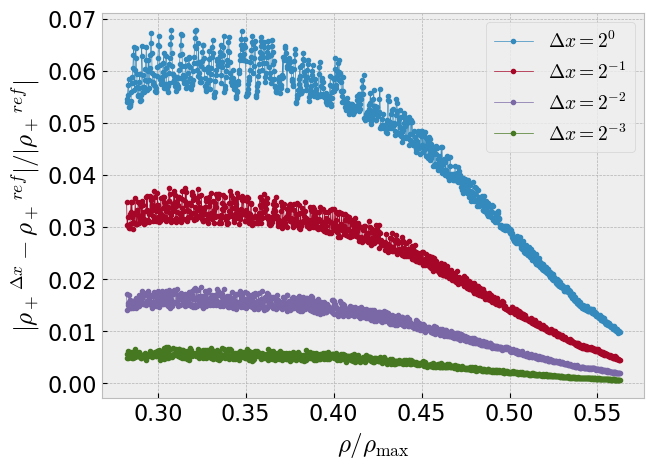

In [40]:
plt.plot(rhos_to_test/rho_max, errors_rho_plus_0, ".-", label=r"$\Delta x = 2^{0}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_rho_plus_1, ".-", label=r"$\Delta x = 2^{-1}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_rho_plus_2, ".-", label=r"$\Delta x = 2^{-2}$", lw=.5)
plt.plot(rhos_to_test/rho_max, errors_rho_plus_3, ".-", label=r"$\Delta x = 2^{-3}$", lw=.5)
#plt.xscale("log")
plt.legend(fontsize=14)
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$|{\rho_+}^{\Delta x} - {\rho_+}^{ref}|/|{\rho_+}^{ref}|$")

#plt.ylim(-0.1, 1000)
plt.savefig("Img/Collisions/rho_plus_difs_dxs_.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [41]:
errors_rho_plus_norm_0 = norm(rho_plus_dx_0 - rho_plus_tau_5, 1)/norm(rho_plus_tau_5, 1)
errors_rho_plus_norm_1 = norm(rho_plus_dx_1 - rho_plus_tau_5, 1)/norm(rho_plus_tau_5, 1)
errors_rho_plus_norm_2 = norm(rho_plus_dx_2 - rho_plus_tau_5, 1)/norm(rho_plus_tau_5, 1)
errors_rho_plus_norm_3 = norm(rho_plus_dx_3 - rho_plus_tau_5, 1)/norm(rho_plus_tau_5, 1)

errors_rho_plus_norm = np.array([errors_rho_plus_norm_0, errors_rho_plus_norm_1, errors_rho_plus_norm_2, errors_rho_plus_norm_3])

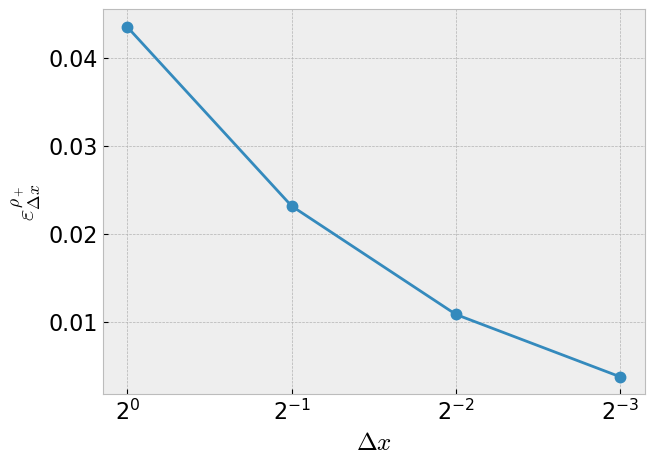

In [42]:
plt.plot(dxs, errors_rho_plus_norm, ".-", ms=15)
#plt.xscale("log")
plt.xscale("log", base=2)

plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$\varepsilon^{\rho_+}_{\Delta x}$")
plt.gca().invert_xaxis()
plt.savefig("Img/Collisions/norm_rho_plus_dxs.pdf", dpi=300, bbox_inches = "tight")
plt.show()